In [1]:
import logging
import os
from pathlib import Path

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import xmltodict
from astropy.coordinates import SkyCoord
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.maps import Map
from gammapy.modeling.models import SPATIAL_MODEL_REGISTRY, SPECTRAL_MODEL_REGISTRY, Models

In [2]:
from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.base.geom import generate_geom, get_source_position
from asgardpy.config import AsgardpyConfig
from asgardpy.data.dataset_3d import Dataset3DGeneration
from asgardpy.data.target import apply_selection_mask_to_models, read_models_from_asgardpy_config
from asgardpy.gammapy.interoperate_models import (
    xml_spectral_model_to_gammapy,
)
from asgardpy.gammapy.read_models import (
    create_source_skymodel,
    read_fermi_xml_models_list,
)

In [3]:
# os.environ['GAMMAPY_DATA']

In [4]:
log = logging.getLogger("test Models from XML")

# Using asgardpy.gammapy.read_models class directly

In [5]:
list_source_models = []
diffuse_models = {}

dl3_dl3_aux_path = Path(f"{os.environ['GAMMAPY_DATA']}fermipy-crab/")

xml_file = dl3_dl3_aux_path / "srcmdl_00.xml"

# Diffuse models if need to be read, else can be kept as an empty dict
diffuse_models["gal_diffuse"] = dl3_dl3_aux_path / "gll_iem_v07_cutout.fits"
diffuse_models["iso_diffuse"] = dl3_dl3_aux_path / "iso_P8R3_SOURCE_V3_FRONT_v1.txt"
diffuse_models["key_name"] = None

In [6]:
%%time
list_source_models, diffuse_models = read_fermi_xml_models_list(
    list_source_models, dl3_dl3_aux_path, xml_file, diffuse_models
)

CPU times: user 443 ms, sys: 7.25 ms, total: 450 ms
Wall time: 448 ms


In [7]:
list_source_models = Models(list_source_models)

In [8]:
print(list_source_models.names)

['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0521.7+2112', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', '4FGL J0521.2+1637', '4FGL J0552.0+2656c', '4FGL J0601.4+2320', '4FGL J0509.1+1943', '4FGL J0533.9+2838', '4FGL J0519.6+2744', '4FGL J0603.9+2159', '4FGL J0510.0+1800', '4FGL J0524.5+2839', '4FGL J0533.5+1449', '4FGL J0539.6+1432', '4FGL J0515.8+1527', '4FGL J0609.0+2136c', '4FGL J0501.0+2424', '4FGL J0608.8+2034c', '4FGL J0609.0+2006', '4FGL J0530.9+1332', '4FGL J0459.4+1921', '4FGL J0531.7+1241c', '4FGL J0614.9+2426', '4FGL J0616.5+2235', '4FGL J0617.2+2234e', '4FGL J0610.7+1656', '4FGL J0452.0+2100', '4FGL J0540.0+1209', '4FGL J0613.1+1749c', '4FGL J0456.2+2702', '4FGL J0554.1+3107', '4FGL J0611.6+2803', '4FGL J0559.6+3044', '4FGL J0548.6+1200', '4FGL J0502.2+3016', '4FGL J0600.3+1244', '4FGL J0612.6+1520c', '4FGL J0502.5+1340', '

# Using AsgardpyConfig specific functions

In [9]:
config_file = "../src/asgardpy/tests/config_test_base.yaml"

In [10]:
config = AsgardpyConfig()

In [11]:
%%time
config_main = config.read(config_file)

CPU times: user 16.1 ms, sys: 1.72 ms, total: 17.8 ms
Wall time: 17.2 ms


# Update path of test data

In [12]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

In [13]:
config_main.general.model_dump()

{'log': {'level': 'info',
  'filename': '',
  'filemode': 'w',
  'format': '',
  'datefmt': ''},
 'outdir': PosixPath('.'),
 'n_jobs': 10,
 'parallel_backend': 'multiprocessing',
 'steps': ['datasets-3d', 'datasets-1d', 'fit', 'flux-points'],
 'overwrite': True,
 'stacked_dataset': True}

# Steps mentioned in the main config file

In [14]:
config_main.general.steps

['datasets-3d', 'datasets-1d', 'fit', 'flux-points']

# Target source information

In [15]:
config_main.target.model_dump()

{'source_name': '4FGL J0534.5+2201i',
 'sky_position': {'frame': 'icrs',
  'lon': <Quantity 83.6338333 deg>,
  'lat': <Quantity 22.0145 deg>,
  'radius': <Quantity 0. deg>},
 'use_uniform_position': True,
 'models_file': PosixPath('.'),
 'datasets_with_fov_bkg_model': [],
 'use_catalog': {'name': '',
  'selection_radius': <Quantity 0. deg>,
  'exclusion_radius': <Quantity 0. deg>},
 'components': [{'name': '4FGL J0534.5+2201i',
   'type': 'SkyModel',
   'datasets_names': [''],
   'spectral': {'type': 'LogParabolaSpectralModel',
    'parameters': [{'name': 'amplitude',
      'value': 1e-06,
      'unit': 'cm-2 s-1 TeV-1',
      'error': 1.5e-07,
      'min': 1e-13,
      'max': 0.01,
      'frozen': False},
     {'name': 'reference',
      'value': 0.015,
      'unit': 'TeV',
      'error': 0.0,
      'min': 0.0001,
      'max': 100.0,
      'frozen': True},
     {'name': 'alpha',
      'value': 1.7,
      'unit': '',
      'error': 0.1,
      'min': 0.5,
      'max': 5.0,
      'frozen

# 3D Datasets informations

In [16]:
config_main.dataset3d.model_dump()

{'type': '3d',
 'instruments': [{'name': 'Fermi-LAT',
   'input_dl3': [{'type': 'lat',
     'input_dir': PosixPath('/home/chaitanya/software/gammapy-datasets/1.3/fermipy-crab'),
     'glob_pattern': {'events': '*ft*.fits*',
      'edisp': 'drm*.fits*',
      'xml_model': 'srcmdl*.xml',
      'exposure': 'bexpmap*.fits*',
      'psf': 'psf*.fits*'}},
    {'type': 'lat-aux',
     'input_dir': PosixPath('/home/chaitanya/software/gammapy-datasets/1.3/fermipy-crab'),
     'glob_pattern': {'gal_diffuse': 'gll_iem_v07_cutout.fits*',
      'iso_diffuse': 'iso_P8R3_SOURCE_V3_*.txt'}}],
   'input_dl4': False,
   'dataset_info': {'name': 'Fermi-LAT',
    'key': ['00', '01'],
    'observation': {'obs_ids': [],
     'obs_file': PosixPath('.'),
     'obs_time': [],
     'obs_cone': {'frame': 'icrs',
      'lon': <Quantity 0. deg>,
      'lat': <Quantity 0. deg>,
      'radius': <Quantity 0. deg>},
     'required_irfs': ['aeff']},
    'map_selection': ['counts', 'exposure', 'background', 'psf', 'edis

In [17]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


CPU times: user 985 μs, sys: 924 μs, total: 1.91 ms
Wall time: 1.51 ms


In [18]:
analysis

# Get XML file from a single 3D Dataset - Fermi-LAT

In [19]:
instruments_list = config_main.dataset3d.instruments
print(len(instruments_list), "number of 3D dataset information provided")

config_3d_dataset = instruments_list[0]
print(f"Instrument selected is {config_3d_dataset.name}")

key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

1 number of 3D dataset information provided
Instrument selected is Fermi-LAT
The list of different keys or modes of observations for the selected instrument are ['00', '01']


In [20]:
%%time
generate_3d_dataset = Dataset3DGeneration(log, config_3d_dataset, analysis.config)

CPU times: user 18 μs, sys: 6 μs, total: 24 μs
Wall time: 28.1 μs


In [21]:
if len(key_names) == 0:
    key_names = [None]

In [22]:
exclusion_regions = []

In [23]:
%%time
file_list = generate_3d_dataset.read_to_objects(key_names[0])

Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.


CPU times: user 645 ms, sys: 19.1 ms, total: 664 ms
Wall time: 661 ms


In [24]:
print(f"The XML file selected is {file_list['xml_file']}")
xml_file = file_list["xml_file"]

The XML file selected is /home/chaitanya/software/gammapy-datasets/1.3/fermipy-crab/srcmdl_00.xml


# Read into Models from XML file

In [25]:
with open(xml_file) as f:
    data = xmltodict.parse(f.read())["source_library"]["source"]

In [26]:
print(
    "The sources for which model information is given in the XML file, along with their spectral and spatial model:"
)
for source in data:
    print(source["@name"], source["spectrum"]["@type"], source["spatialModel"]["@type"])

The sources for which model information is given in the XML file, along with their spectral and spatial model:
4FGL J0534.5+2201i LogParabola RadialGaussian
4FGL J0534.5+2201s PowerLaw SkyDirFunction
4FGL J0534.5+2200 PLSuperExpCutoff2 SkyDirFunction
4FGL J0526.3+2246 PowerLaw SkyDirFunction
4FGL J0544.4+2238 PowerLaw SkyDirFunction
4FGL J0521.7+2112 LogParabola SkyDirFunction
4FGL J0528.3+1817 PowerLaw SkyDirFunction
4FGL J0536.2+1733 LogParabola SkyDirFunction
4FGL J0550.9+2552c PowerLaw SkyDirFunction
4FGL J0539.0+1644 PowerLaw SkyDirFunction
4FGL J0534.2+2751 PowerLaw SkyDirFunction
4FGL J0540.3+2756e LogParabola SpatialMap
4FGL J0521.2+1637 PowerLaw SkyDirFunction
4FGL J0552.0+2656c PowerLaw SkyDirFunction
4FGL J0601.4+2320 PowerLaw SkyDirFunction
4FGL J0509.1+1943 PowerLaw SkyDirFunction
4FGL J0533.9+2838 PowerLaw SkyDirFunction
4FGL J0519.6+2744 PowerLaw SkyDirFunction
4FGL J0603.9+2159 PowerLaw SkyDirFunction
4FGL J0510.0+1800 LogParabola SkyDirFunction
4FGL J0524.5+2839 PowerL

In [27]:
print("Diffuse Isotropic Model already initialized")
print(generate_3d_dataset.diffuse_models["iso_diffuse"])

Diffuse Isotropic Model already initialized
SkyModel

  Name                      : fermi-diffuse-iso-00
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ConstantSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         
    value                 (frozen):      1.000       1 / sr      




In [28]:
print(generate_3d_dataset.diffuse_models["gal_diffuse"])

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    187.750       deg         
    lat_0                 (frozen):     -5.812       deg         




In [29]:
dl3_aux_path = generate_3d_dataset.config_3d_dataset.input_dl3[1].input_dir
print(dl3_aux_path)

/home/chaitanya/software/gammapy-datasets/1.3/fermipy-crab


In [30]:
# Check if the Spectral Model type is properly translated
for source in data:
    source_name = source["@name"]
    if source_name not in ["IsoDiffModel", "GalDiffModel", "isodiff", "galdiff"]:
        spectrum_ = source["spectrum"]["parameter"]
        spectrum_type = source["spectrum"]["@type"].split("EblAtten::")[-1]

        if spectrum_[0]["@name"] not in ["GalDiffModel", "IsoDiffModel"]:
            if spectrum_type in ["PLSuperExpCutoff", "PLSuperExpCutoff2"]:
                spectrum_type_final = "ExpCutoffPowerLawSpectralModel"
            elif spectrum_type == "PLSuperExpCutoff4":
                spectrum_type_final = "SuperExpCutoffPowerLaw4FGLDR3SpectralModel"
            else:
                spectrum_type_final = f"{spectrum_type}SpectralModel"

            spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls(spectrum_type_final)()

            if spectrum_type == "LogParabola":
                if "EblAtten" in source["spectrum"]["@type"]:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls("PowerLawSpectralModel")()
                    ebl_atten_pl = True
                else:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls("LogParabolaSpectralModel")()
        print(spectrum_type, spectral_model.tag)

LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PLSuperExpCutoff2 ['ExpCutoffPowerLawSpectralModel', 'ecpl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLa

In [31]:
# Check if the Spectral Model parameters are properly translated
for source in data:
    source_name = source["@name"]

    if source_name not in ["IsoDiffModel", "GalDiffModel", "isodiff", "galdiff"]:
        print(f"\n{source_name}\n")
        spectrum_ = source["spectrum"]["parameter"]
        spectrum_type = source["spectrum"]["@type"].split("EblAtten::")[-1]

        print(spectrum_type)
        for p in spectrum_:
            print(f'Name: {p["@name"]:12s} \tScale: {float(p["@scale"]):6e} \tFrozen: {p["@free"]}')
            print(
                f'Value: {(float(p["@value"]) * float(p["@scale"])):.6e}'
                + f' \tMin: {(float(p["@min"]) * float(p["@scale"])):.6e}'
                + f' \tMax: {(float(p["@max"]) * float(p["@scale"])):.6e}'
            )

        if spectrum_[0]["@name"] not in ["GalDiffModel", "IsoDiffModel"]:
            if spectrum_type in ["PLSuperExpCutoff", "PLSuperExpCutoff2"]:
                spectrum_type_final = "ExpCutoffPowerLawSpectralModel"
            elif spectrum_type == "PLSuperExpCutoff4":
                spectrum_type_final = "SuperExpCutoffPowerLaw4FGLDR3SpectralModel"
            else:
                spectrum_type_final = f"{spectrum_type}SpectralModel"

            spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls(spectrum_type_final)()

            if spectrum_type == "LogParabola":
                if "EblAtten" in source["spectrum"]["@type"]:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls("PowerLawSpectralModel")()
                    ebl_atten_pl = True
                else:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls("LogParabolaSpectralModel")()
        # Read the parameter values from XML file to create SpectralModel
        params_list = xml_spectral_model_to_gammapy(
            spectrum_,
            spectrum_type,
        )
        print("\n", spectral_model.tag)
        for p in params_list:
            print(f"Name: {p.name:12s} \tScale: {p.scale} \t\tFrozen:{p.frozen}")
            print(f"Value: {p.value:.6e} \tMin: {p.min:.6e} \tMax: {p.max:.6e}")


4FGL J0534.5+2201i

LogParabola
Name: Eb           	Scale: 1.000000e+03 	Frozen: 0
Value: 1.000000e+04 	Min: 1.000000e+02 	Max: 1.000000e+05
Name: alpha        	Scale: 1.000000e+00 	Frozen: 0
Value: 1.750000e+00 	Min: 0.000000e+00 	Max: 5.000000e+00
Name: beta         	Scale: 1.000000e-01 	Frozen: 0
Value: 8.000000e-02 	Min: -5.000000e-01 	Max: 1.000000e+00
Name: norm         	Scale: 1.000000e-13 	Frozen: 0
Value: 5.500000e-13 	Min: 0.000000e+00 	Max: 1.000000e-11

 ['LogParabolaSpectralModel', 'lp']
Name: reference    	Scale: 1.0 		Frozen:True
Value: 1.000000e-02 	Min: 1.000000e-04 	Max: 1.000000e-01
Name: alpha        	Scale: 1.0 		Frozen:True
Value: 1.750000e+00 	Min: 0.000000e+00 	Max: 5.000000e+00
Name: beta         	Scale: 1.0 		Frozen:True
Value: 8.000000e-02 	Min: -5.000000e-01 	Max: 1.000000e+00
Name: amplitude    	Scale: 1.0 		Frozen:True
Value: 5.500000e-07 	Min: 0.000000e+00 	Max: 1.000000e-05

4FGL J0534.5+2201s

PowerLaw
Name: Index        	Scale: -1.000000e+00 	Frozen: 

# Get the list of source models

In [32]:
list_source_models = []
is_target_source = False

for source in data:
    source_name = source["@name"]
    if source_name not in ["IsoDiffModel", "GalDiffModel", "isodiff", "galdiff"]:
        source, is_target_source = create_source_skymodel(
            source, dl3_aux_path, asgardpy_target_config=analysis.config.target
        )

        if is_target_source:
            list_source_models.insert(0, source)
        else:
            list_source_models.append(source)

In [33]:
list_source_models.append(generate_3d_dataset.diffuse_models["iso_diffuse"])

In [34]:
print(len(list_source_models))

54


In [35]:
for m in list_source_models:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.100   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         


Sky

In [36]:
target_pos = Models(list_source_models)[config_main.target.source_name].spatial_model.position.icrs
for m in list_source_models:
    print("\n", m.name)
    if m.spatial_model.position:
        print(
            f"Separation from Target source is {target_pos.separation(m.spatial_model.position.icrs).deg:.3f} deg"
        )
    if m.spectral_model.tag[1] == "compound":
        print(m.spectral_model.model1.tag[0])
    else:
        print(m.spectral_model.tag[0])
    for p in m.spectral_model.parameters:
        print(p.name)


 4FGL J0534.5+2201i
Separation from Target source is 0.000 deg
LogParabolaSpectralModel
amplitude
reference
alpha
beta
alpha_norm
redshift

 4FGL J0534.5+2201s
Separation from Target source is 0.000 deg
PowerLawSpectralModel
index
amplitude
reference

 4FGL J0534.5+2200
Separation from Target source is 0.006 deg
ExpCutoffPowerLawSpectralModel
index
amplitude
reference
lambda_
alpha

 4FGL J0526.3+2246
Separation from Target source is 2.034 deg
PowerLawSpectralModel
index
amplitude
reference

 4FGL J0544.4+2238
Separation from Target source is 2.373 deg
PowerLawSpectralModel
index
amplitude
reference

 4FGL J0521.7+2112
Separation from Target source is 3.072 deg
LogParabolaSpectralModel
amplitude
reference
alpha
beta

 4FGL J0528.3+1817
Separation from Target source is 3.996 deg
PowerLawSpectralModel
index
amplitude
reference

 4FGL J0536.2+1733
Separation from Target source is 4.486 deg
LogParabolaSpectralModel
amplitude
reference
alpha
beta

 4FGL J0550.9+2552c
Separation from Target

(1e-13, 1e-08)

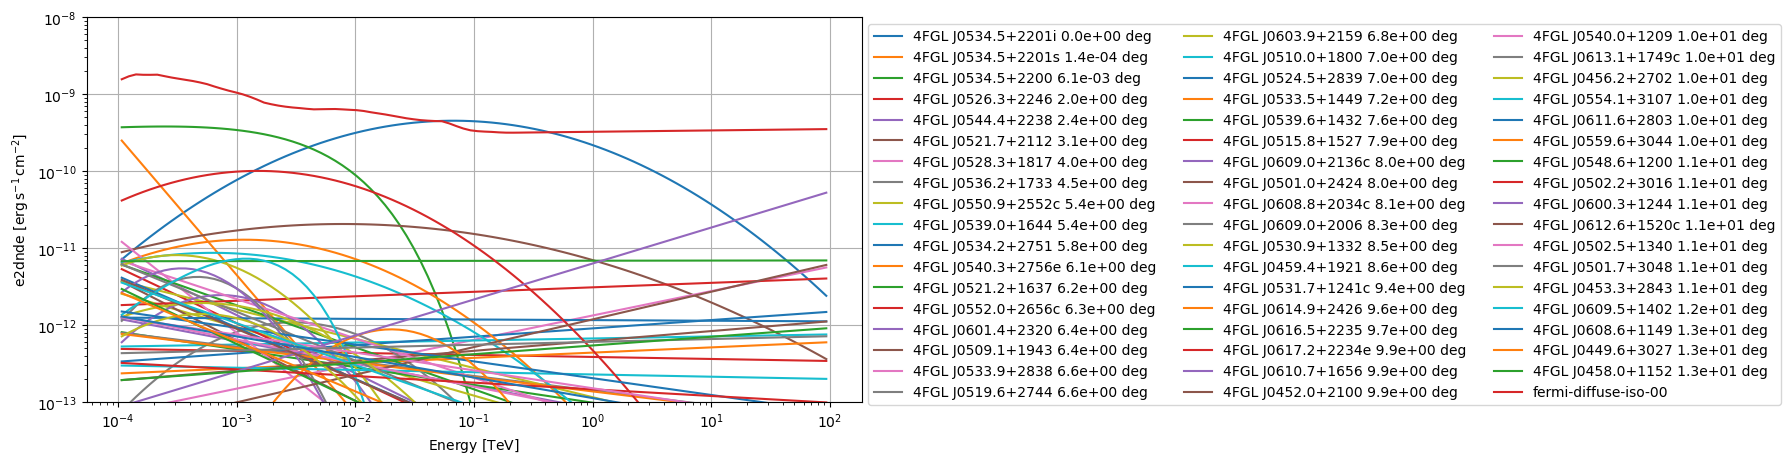

In [37]:
plt.figure(figsize=(10, 5))
en_b = [1e-4, 1e2] * u.TeV
for m in list_source_models:
    if m.spatial_model.position:
        label_ = f"{m.name} {target_pos.separation(m.spatial_model.position.icrs).deg:.1e} deg"
    else:
        label_ = m.name
    m.spectral_model.plot(energy_bounds=en_b, sed_type="e2dnde", label=label_)

plt.grid()
plt.legend(bbox_to_anchor=(1, 1), ncols=int(np.sqrt(len(list_source_models)) / 2))
plt.ylim(1e-13, 1e-8)

# Spatial Models

In [38]:
for source in data:
    print(source["@name"])
    xml_spatial_model = source["spatialModel"]
    spatial_pars = xml_spatial_model["parameter"]

    if xml_spatial_model["@type"] == "SkyDirFunction":
        for par_ in spatial_pars:
            print(par_)
            if par_["@name"] == "RA":
                lon_0 = f"{par_['@value']} deg"
            if par_["@name"] == "DEC":
                lat_0 = f"{par_['@value']} deg"
        fk5_frame = SkyCoord(
            lon_0,
            lat_0,
            frame="fk5",
        )
        gal_frame = fk5_frame.transform_to("galactic")
        spatial_model = SPATIAL_MODEL_REGISTRY.get_cls("PointSpatialModel")().from_position(gal_frame)

    elif xml_spatial_model["@type"] == "SpatialMap":
        file_name = xml_spatial_model["@file"].split("/")[-1]
        file_path = dl3_aux_path / f"Templates/{file_name}"

        spatial_map = Map.read(file_path)
        spatial_map = spatial_map.copy(unit="sr^-1")

        spatial_model = SPATIAL_MODEL_REGISTRY.get_cls("TemplateSpatialModel")(spatial_map, filename=file_path)

    elif xml_spatial_model["@type"] == "RadialGaussian":
        for par_ in spatial_pars:
            print(par_)
            if par_["@name"] == "RA":
                lon_0 = f"{par_['@value']} deg"
            if par_["@name"] == "DEC":
                lat_0 = f"{par_['@value']} deg"
            if par_["@name"] == "Sigma":
                sigma = f"{par_['@value']} deg"
        fk5_frame_ = SkyCoord(
            lon_0,
            lat_0,
            frame="fk5",
        )
        print(fk5_frame_)
        gal_frame = fk5_frame_.transform_to("galactic")

        spatial_model = SPATIAL_MODEL_REGISTRY.get_cls("GaussianSpatialModel")(
            lon_0=gal_frame.l, lat_0=gal_frame.b, sigma=sigma, frame="galactic"
        )

    print(spatial_model.position)

4FGL J0534.5+2201i
{'@free': '0', '@max': '90.0', '@min': '-90.0', '@name': 'DEC', '@scale': '1.0', '@value': '22.02'}
{'@free': '0', '@max': '360.0', '@min': '0.0', '@name': 'RA', '@scale': '1.0', '@value': '83.633'}
{'@free': '0', '@max': '10.0', '@min': '0.0', '@name': 'Sigma', '@scale': '1.0', '@value': '0.02'}
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (83.633, 22.02)>
<SkyCoord (Galactic): (l, b) in deg
    (184.55273876, -5.78148086)>
4FGL J0534.5+2201s
{'@free': '0', '@max': '90.0', '@min': '-90.0', '@name': 'DEC', '@scale': '1.0', '@value': '22.0199'}
{'@free': '0', '@max': '360.0', '@min': '-360.0', '@name': 'RA', '@scale': '1.0', '@value': '83.6331'}
<SkyCoord (Galactic): (l, b) in deg
    (184.55287354, -5.78145609)>
4FGL J0534.5+2200
{'@free': '0', '@max': '90.0', '@min': '-90.0', '@name': 'DEC', '@scale': '1.0', '@value': '22.0149'}
{'@free': '0', '@max': '360.0', '@min': '-360.0', '@name': 'RA', '@scale': '1.0', '@value': '83.6367'}
<SkyCoord (Galactic): (l

In [39]:
for m in list_source_models:
    print("\n", m.name, m.spatial_model.tag)
    print(m.spatial_model, m.spatial_model.evaluation_radius)


 4FGL J0534.5+2201i ['GaussianSpatialModel', 'gauss']
GaussianSpatialModel

type  name    value    unit   error      min        max    frozen link prior
---- ----- ----------- ---- --------- ---------- --------- ------ ---- -----
     lon_0  1.8455e+02  deg 0.000e+00        nan       nan   True           
     lat_0 -5.7815e+00  deg 0.000e+00 -9.000e+01 9.000e+01   True           
     sigma  2.0000e-02  deg 0.000e+00  0.000e+00       nan   True           
         e  0.0000e+00      0.000e+00  0.000e+00 1.000e+00   True           
       phi  0.0000e+00  deg 0.000e+00        nan       nan   True            0.1 deg

 4FGL J0534.5+2201s ['PointSpatialModel', 'point']
PointSpatialModel

type  name    value    unit   error      min        max    frozen link prior
---- ----- ----------- ---- --------- ---------- --------- ------ ---- -----
     lon_0  3.2211e+00  rad 0.000e+00        nan       nan   True           
     lat_0 -1.0091e-01  rad 0.000e+00 -9.000e+01 9.000e+01   True         

4FGL J0534.5+2201i GaussianSpatialModel

type  name    value    unit   error      min        max    frozen link prior
---- ----- ----------- ---- --------- ---------- --------- ------ ---- -----
     lon_0  1.8455e+02  deg 0.000e+00        nan       nan   True           
     lat_0 -5.7815e+00  deg 0.000e+00 -9.000e+01 9.000e+01   True           
     sigma  2.0000e-02  deg 0.000e+00  0.000e+00       nan   True           
         e  0.0000e+00      0.000e+00  0.000e+00 1.000e+00   True           
       phi  0.0000e+00  deg 0.000e+00        nan       nan   True           


<WCSAxes: >

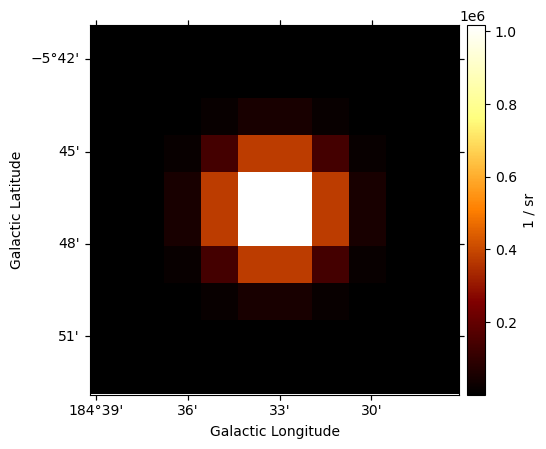

In [40]:
idx = 0
print(list_source_models[idx].name, list_source_models[idx].spatial_model)
test_ = list_source_models[idx].spatial_model
test_.plot(add_cbar=True)

# Reading models from Config file

In [41]:
model = read_models_from_asgardpy_config(analysis.config.target)

In [42]:
print(model[0].spectral_model)

CompoundSpectralModel
    Component 1 : LogParabolaSpectralModel

type    name     value         unit      ...    max    frozen link prior
---- --------- ---------- -------------- ... --------- ------ ---- -----
     amplitude 1.0000e-06 TeV-1 s-1 cm-2 ... 1.000e-02  False           
     reference 1.5000e-02            TeV ... 1.000e+02   True           
         alpha 1.7000e+00                ... 5.000e+00  False           
          beta 1.0000e-01                ... 1.000e+00  False           
    Component 2 : EBLAbsorptionNormSpectralModel

type    name      value    unit   error   min max frozen link prior
---- ---------- ---------- ---- --------- --- --- ------ ---- -----
     alpha_norm 1.0000e+00      0.000e+00 nan nan   True           
       redshift 0.0000e+00      0.000e+00 nan nan   True           
    Operator : mul



In [43]:
print(model[0].spatial_model)

None


# Apply selection mask to list of models

In [44]:
list_source_models = apply_selection_mask_to_models(
    list_source_models,
    target_source=analysis.config.target.source_name,
    roi_radius=analysis.config.target.roi_selection.roi_radius,
    free_sources=analysis.config.target.roi_selection.free_sources,
)

In [45]:
for m in list_source_models:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.100   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         


Sky

In [46]:
print(len(list_source_models))

54


In [47]:
print(len(list_source_models.parameters.free_parameters))

8


# Get models from Catalog

In [48]:
base_geom = generate_geom(
    tag="3d",
    geom_config=analysis.config.dataset3d.instruments[0].dataset_info.geom,
    center_pos=get_source_position(analysis.config.target.sky_position),
)

In [49]:
analysis.config.target.use_catalog.selection_radius = 0.2 * u.deg
analysis.config.target.use_catalog.name = "4fgl"
list_source_models = []

In [50]:
%%time
catalog = CATALOG_REGISTRY.get_cls(analysis.config.target.use_catalog.name)()
print(len(catalog.positions))

inside_geom = base_geom.to_image().contains(catalog.positions)

idx_list = np.nonzero(inside_geom)[0]
print(len(idx_list))

for i in idx_list:
    list_source_models.append(catalog[i].sky_model())

7195
4
CPU times: user 390 ms, sys: 11 ms, total: 401 ms
Wall time: 400 ms


In [51]:
for m_ in list_source_models:
    print(m_.name)

4FGL J0526.3+2246
4FGL J0534.5+2201i
4FGL J0534.5+2201s
4FGL J0534.5+2200


In [52]:
for m_ in list_source_models:
    print(m_)

SkyModel

  Name                      : 4FGL J0526.3+2246
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.185   +/-    0.15             
    amplitude                     :   1.58e-14   +/- 2.7e-15 1 / (MeV s cm2)
    reference             (frozen):   4184.775       MeV         
    lon_0                         :     81.591   +/-    0.02 deg         
    lat_0                         :     22.778   +/-    0.02 deg         


SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   5.50e-13   +/- 0.0e+00 1 / (MeV s cm2)
    reference             (frozen):  10000.000       MeV         
    alp